### Character Segmentation
#### Theory

In this lab, we focus on character segmentation, a crucial step in Optical Character Recognition (OCR) systems. The process involves isolating individual characters from an image, enabling further analysis such as character recognition. The key steps include:

1. **Preprocessing the Image**: Converting the input image to grayscale and applying adaptive thresholding to create a binary image. This step enhances the contrast between the foreground (characters) and the background.

2. **Extracting Characters**: Using contour detection to identify regions of interest (ROIs) corresponding to individual characters. Bounding boxes are computed to isolate these regions.

3. **Visualization**: Displaying the original image alongside the segmented characters with bounding boxes to verify the accuracy of the segmentation process.

**Objectives**:
- Understand the preprocessing techniques required for character segmentation.
- Implement contour-based methods to extract individual characters.
- Visualize and validate the segmentation results.

In [91]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [92]:
def preprocess_image(image_path):
	img = cv2.imread(image_path)
	gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
	binary = cv2.adaptiveThreshold(
		gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 15, 10
	)
	kernel = np.ones((3, 3), np.uint8)
	binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
	return img, gray, binary


def extract_characters(binary_image, min_area=100):
	contours, _ = cv2.findContours(
		binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
	)
	bounding_boxes = []
	characters = []

	for cnt in contours:
		x, y, w, h = cv2.boundingRect(cnt)
		area = w * h
		if area > min_area:
			roi = binary_image[y : y + h, x : x + w]
			characters.append(roi)
			bounding_boxes.append((x, y, w, h))
	characters = [
		char
		for _, char in sorted(zip(bounding_boxes, characters), key=lambda b: b[0][0])
	]
	bounding_boxes = sorted(bounding_boxes, key=lambda b: b[0])

	return characters, bounding_boxes


def visualize(image, boxes, characters):
	plt.figure(figsize=(15, 10))

	plt.subplot(1, 2, 1)
	plt.title("Original Image")
	plt.imshow(image, cmap="gray")
	plt.axis("off")

	segmented = image.copy()
	for x, y, w, h in boxes:
		cv2.rectangle(segmented, (x, y), (x + w, y + h), (0, 255, 0), 1)

	plt.subplot(1, 2, 2)
	plt.title("Bounding Boxes")
	plt.imshow(cv2.cvtColor(segmented, cv2.COLOR_BGR2RGB))
	plt.axis("off")
	plt.tight_layout()


def segment_characters(image_path, min_area=100):
	image, gray, binary = preprocess_image(image_path)
	characters, boxes = extract_characters(binary, min_area)
	visualize(image.copy(), boxes, characters)

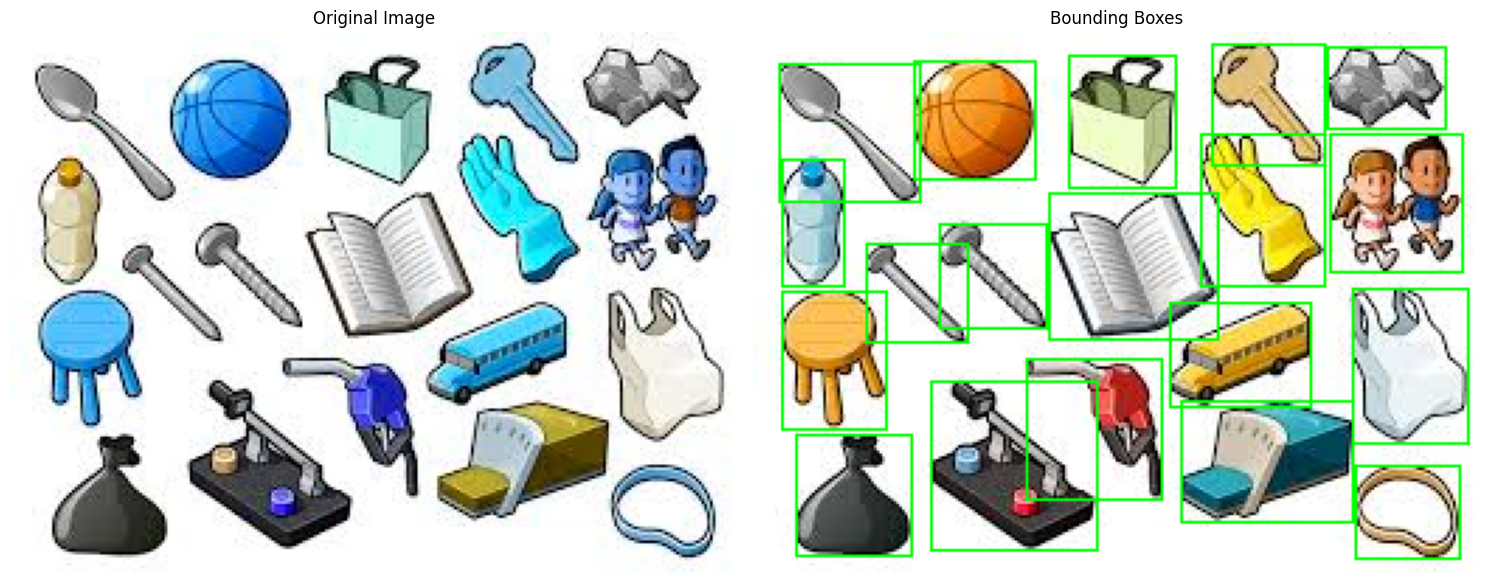

In [93]:
image, gray, binary = preprocess_image("stdimgs/objects.jpeg")
characters, boxes = extract_characters(binary, 100)
visualize(image.copy(), boxes, characters)